## Shooting Method:

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
import time
from sklearn.metrics import mean_squared_error

In [20]:
# Define the fast system ODE
def fast_system(t, y):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Define the slow system ODE
def slow_system(tau, y):
    x, y, z = y
    dxdtau = -x / eps
    dydtau = (2 * y + eps * x) / eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

# Define the backward fast system ODE
def fast2_system(t, y):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Boundary conditions and constants
x_init, y_init, z_init = 1.0, 0.0, 0.0
x_end, y_end, z_end = 0.0, 1.0, 1.0
eps = 0.01
t_end = 100
tau_end = 1

t  =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0, -t_end, 100)
tau = np.linspace(0, tau_end, 100)

# Exact solutions (optional validation functions)
def fast_solution(t, x0, y0, z0):
    x_exact = x0 * np.exp(-t)
    y_exact = y0 * np.exp(2 * t)
    z_exact = np.full_like(t, z0)
    return x_exact, y_exact, z_exact

def slow_solution(tau, x0, y0, z0):
    x_exact = np.full_like(tau, 0)
    y_exact = np.full_like(tau, 0)
    z_exact = z0 + tau
    return x_exact, y_exact, z_exact




# Compute exact solutions
start_time_exact = time.time()
x_exact_fast, y_exact_fast, z_exact_fast = fast_solution(t, x_init, y_init, z_init)
xf_end, yf_end, zf_end = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]
x_exact_slow, y_exact_slow, z_exact_slow = slow_solution(tau, xf_end, yf_end, zf_end)
x_exact_fast2, y_exact_fast2, z_exact_fast2 = fast_solution(t2, x_end, y_end, z_end)
xf2_end, yf2_end, zf2_end = x_exact_fast2[-1], y_exact_fast2[-1], z_exact_fast2[-1]   
time_exact = time.time() - start_time_exact



# Shooting method to match boundary conditions
def shooting_method(guess):
    # Unpack the guess for intermediate states
    x_f, y_f, z_f = guess[:3]  # Guess for (x_f, y_f, z_f)
    x_f2, y_f2, z_f2 = guess[3:]  # Guess for (x_f2, y_f2, z_f2)

    # First piece: Fast system (forward) from (x_init, y_init, z_init) to (x_f, y_f, z_f)
    sol_fast = solve_ivp(fast_system, [0, t_end], [x_init, y_init, z_init], t_eval=[t_end])
    #xf_end, yf_end, zf_end = sol_fast.y[:, -1]
    xf_end, yf_end, zf_end = 0.0, 0.0, 0.0

    # Enforce continuity: Ensure sol_fast ends at (x_f, y_f, z_f)
    residual_fast = [xf_end - x_f, yf_end - y_f, zf_end - z_f]

    # Second piece: Slow system from (x_f, y_f, z_f) to (x_f2, y_f2, z_f2)
    sol_slow = solve_ivp(slow_system, [0, tau_end], [x_f, y_f, z_f], t_eval=[tau_end])
    #xf2_end, yf2_end, zf2_end = sol_slow.y[:, -1]
    xf2_end, yf2_end, zf2_end = 0.0, 0.0, 1.0

    # Enforce continuity: Ensure sol_slow ends at (x_f2, y_f2, z_f2)
    residual_slow = [xf2_end - x_f2, yf2_end - y_f2, zf2_end - z_f2]

    # Third piece: Fast2 system (backward) from (x_f2, y_f2, z_f2) to (x_end, y_end, z_end)
    sol_fast2 = solve_ivp(fast2_system, [0, t_end], [x_f2, y_f2, z_f2], t_eval=[t_end])
    xf2_check, yf2_check, zf2_check = sol_fast2.y[:, -1]

    # Enforce final boundary condition: Ensure sol_fast2 ends at (x_end, y_end, z_end)
    residual_fast2 = [xf2_check - x_end, yf2_check - y_end, zf2_check - z_end]

    # Combine residuals (6 equations for 6 unknowns)
    residuals = residual_fast + residual_slow 
    return residuals

# Initial guess for intermediate states
initial_guess = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

# Solve the shooting problem using root finding
start_time_shooting = time.time()
result = root(shooting_method, initial_guess)

# Check if the shooting method succeeded
if result.success:
    # Extract the corrected intermediate states
    x_f, y_f, z_f, x_f2, y_f2, z_f2 = result.x
    print("Shooting method succeeded!")
    print(f"Intermediate states: (x_f, y_f, z_f) = ({x_f:.3f}, {y_f:.3f}, {z_f:.3f})")
    print(f"Intermediate states: (x_f2, y_f2, z_f2) = ({x_f2:.3f}, {y_f2:.3f}, {z_f2:.3f})")

    # Evaluate solutions with the corrected guess
    sol_fast = solve_ivp(fast_system, [0, t_end], [x_init, y_init, z_init], dense_output=True)
    sol_slow = solve_ivp(slow_system, [0, tau_end], [x_f, y_f, z_f], dense_output=True)
    sol_fast2 = solve_ivp(fast2_system, [0, -t_end], [x_f2, y_f2, z_f2], dense_output=True)

    # Print results
    print("Final states:")
    print("Fast System End:", sol_fast.y[:, -1])
    print("Slow System End:", sol_slow.y[:, -1])
    print("Fast2 System End:", sol_fast2.y[:, -1])
else:
    print("Shooting method failed:", result.message)

# Timing information
time_shooting = time.time() - start_time_shooting
print(f"Shooting method completed in {time_shooting:.3f} seconds.")


Shooting method succeeded!
Intermediate states: (x_f, y_f, z_f) = (0.000, 0.000, -0.000)
Intermediate states: (x_f2, y_f2, z_f2) = (0.000, 0.000, 1.000)
Final states:
Fast System End: [3.90429009e-44 2.21561476e+84 1.00499582e+00]
Slow System End: [0. 0. 1.]
Fast2 System End: [8.20001031e-13 1.72824635e-09 1.11022302e-16]
Shooting method completed in 0.376 seconds.


In [21]:
print("\nCalculating error metrics...")
    # Fast forward system MSE
mse_x_shooting_fast = mean_squared_error(x_exact_fast, sol_fast.sol(t)[0])
mse_y_shooting_fast = mean_squared_error(y_exact_fast, sol_fast.sol(t)[1])
mse_z_shooting_fast = mean_squared_error(z_exact_fast, sol_fast.sol(t)[2])

# Slow system MSE
mse_x_shooting_slow = mean_squared_error(x_exact_slow, sol_slow.sol(tau)[0])
mse_y_shooting_slow = mean_squared_error(y_exact_slow, sol_slow.sol(tau)[1])
mse_z_shooting_slow = mean_squared_error(z_exact_slow, sol_slow.sol(tau)[2])

# Backward fast system MSE
mse_x_shooting_fast2 = mean_squared_error(x_exact_fast2, sol_fast2.sol(t2)[0])
mse_y_shooting_fast2 = mean_squared_error(y_exact_fast2, sol_fast2.sol(t2)[1])
mse_z_shooting_fast2 = mean_squared_error(z_exact_fast2, sol_fast2.sol(t2)[2])

mse_total_fast = (mse_x_shooting_fast + mse_y_shooting_fast + mse_z_shooting_fast) / 3
mse_total_slow = (mse_x_shooting_slow + mse_y_shooting_slow + mse_z_shooting_slow) / 3
mse_total_fast2 = (mse_x_shooting_fast2 + mse_y_shooting_fast2 + mse_z_shooting_fast2) / 3


print("\n===== Performance Comparison =====")
print("\nComputation Time:")
print(f"Exact Solution: {time_exact:.4f} seconds")
print(f"shooting Solution: {time_shooting:.4f} seconds")

print("\nMean Squared Error:")
print("\nFast System:")
print(f"MSE x: {mse_x_shooting_fast:.2e}")
print(f"MSE y: {mse_y_shooting_fast:.2e}")
print(f"MSE z: {mse_z_shooting_fast:.2e}")
print(f"Average MSE: {mse_total_fast:.2e}")

print("\nSlow System:")
print(f"MSE x: {mse_x_shooting_slow:.2e}")
print(f"MSE y: {mse_y_shooting_slow:.2e}")
print(f"MSE z: {mse_z_shooting_slow:.2e}")
print(f"Average MSE: {mse_total_slow:.2e}")

print("\nSecond Fast System:")
print(f"MSE x: {mse_x_shooting_fast2:.2e}")
print(f"MSE y: {mse_y_shooting_fast2:.2e}")
print(f"MSE z: {mse_z_shooting_fast2:.2e}")
print(f"Average MSE: {mse_total_fast2:.2e}")


Calculating error metrics...

===== Performance Comparison =====

Computation Time:
Exact Solution: 0.0003 seconds
shooting Solution: 0.3759 seconds

Mean Squared Error:

Fast System:
MSE x: 5.47e-12
MSE y: 5.00e+166
MSE z: 3.40e-01
Average MSE: 1.67e+166

Slow System:
MSE x: 0.00e+00
MSE y: 0.00e+00
MSE z: 1.05e-32
Average MSE: 3.50e-33

Second Fast System:
MSE x: 2.42e-24
MSE y: 1.02e-02
MSE z: 3.35e-01
Average MSE: 1.15e-01


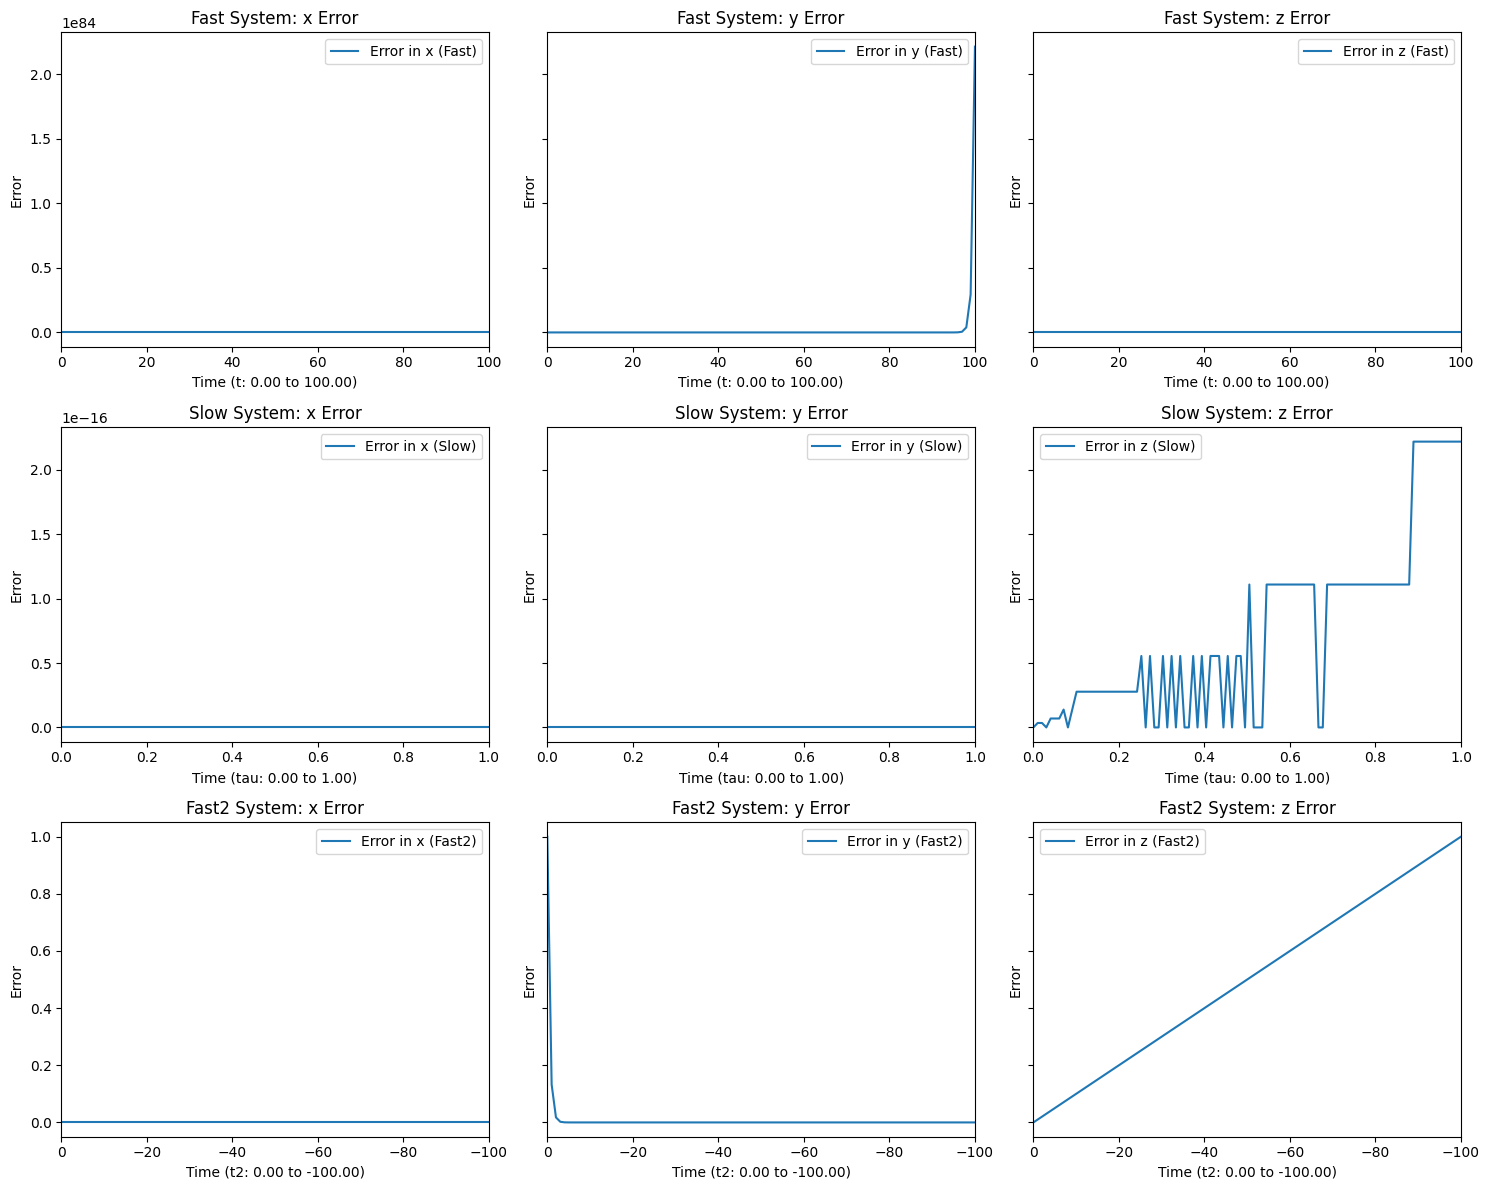

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Error calculations
x_error_fast = np.abs(sol_fast.sol(t)[0] - x_exact_fast)
y_error_fast = np.abs(sol_fast.sol(t)[1] - y_exact_fast)
z_error_fast = np.abs(sol_fast.sol(t)[2] - z_exact_fast)

x_error_slow = np.abs(sol_slow.sol(tau)[0] - x_exact_slow)
y_error_slow = np.abs(sol_slow.sol(tau)[1] - y_exact_slow)
z_error_slow = np.abs(sol_slow.sol(tau)[2] - z_exact_slow)

x_error_fast2 = np.abs(sol_fast2.sol(t2)[0] - x_exact_fast2)
y_error_fast2 = np.abs(sol_fast2.sol(t2)[1] - y_exact_fast2)
z_error_fast2 = np.abs(sol_fast2.sol(t2)[2] - z_exact_fast2)

# Create a single figure with a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey='row')

# Plot errors for fast system
axs[0, 0].plot(t, x_error_fast, label="Error in x (Fast)")
axs[0, 0].set_xlim(t[0], t[-1])
axs[0, 0].set_title("Fast System: x Error")
axs[0, 1].plot(t, y_error_fast, label="Error in y (Fast)")
axs[0, 1].set_xlim(t[0], t[-1])
axs[0, 1].set_title("Fast System: y Error")
axs[0, 2].plot(t, z_error_fast, label="Error in z (Fast)")
axs[0, 2].set_xlim(t[0], t[-1])
axs[0, 2].set_title("Fast System: z Error")

# Plot errors for slow system
axs[1, 0].plot(tau, x_error_slow, label="Error in x (Slow)")
axs[1, 0].set_xlim(tau[0], tau[-1])
axs[1, 0].set_title("Slow System: x Error")
axs[1, 1].plot(tau, y_error_slow, label="Error in y (Slow)")
axs[1, 1].set_xlim(tau[0], tau[-1])
axs[1, 1].set_title("Slow System: y Error")
axs[1, 2].plot(tau, z_error_slow, label="Error in z (Slow)")
axs[1, 2].set_xlim(tau[0], tau[-1])
axs[1, 2].set_title("Slow System: z Error")

# Plot errors for fast2 system
axs[2, 0].plot(t2, x_error_fast2, label="Error in x (Fast2)")
axs[2, 0].set_xlim(t2[0], t2[-1])
axs[2, 0].set_title("Fast2 System: x Error")
axs[2, 1].plot(t2, y_error_fast2, label="Error in y (Fast2)")
axs[2, 1].set_xlim(t2[0], t2[-1])
axs[2, 1].set_title("Fast2 System: y Error")
axs[2, 2].plot(t2, z_error_fast2, label="Error in z (Fast2)")
axs[2, 2].set_xlim(t2[0], t2[-1])
axs[2, 2].set_title("Fast2 System: z Error")

# Add labels, legends, and adjust axes
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.set_xlabel("Time")
        ax.set_ylabel("Error")
        ax.legend()
        if i == 2:  # Add time interval explicitly for the bottom row
            ax.set_xlabel(f"Time (t2: {t2[0]:.2f} to {t2[-1]:.2f})")
        elif i == 1:  # Middle row for tau
            ax.set_xlabel(f"Time (tau: {tau[0]:.2f} to {tau[-1]:.2f})")
        elif i == 0:  # Top row for t
            ax.set_xlabel(f"Time (t: {t[0]:.2f} to {t[-1]:.2f})")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


/tmp/ipykernel_30/3444216240.py:66: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_30/3444216240.py:67: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_30/3444216240.py:68: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


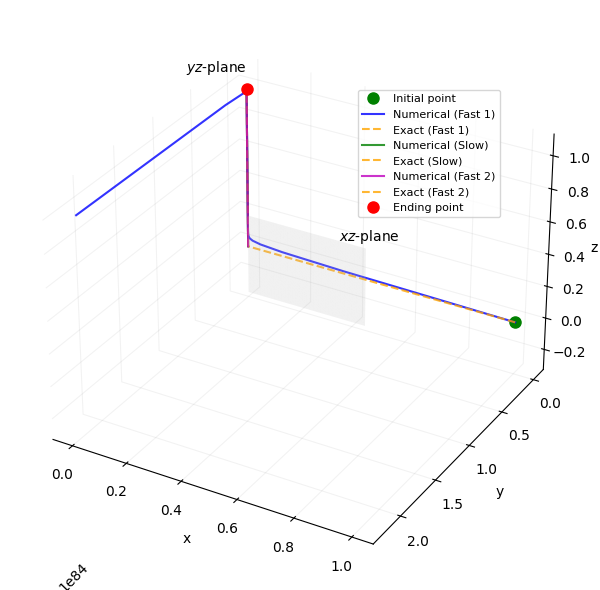

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
x_fast, y_fast, z_fast = sol_fast.sol(t)
x_slow, y_slow, z_slow = sol_slow.sol(tau)
x_fast2, y_fast2, z_fast2 = sol_fast2.sol(t2)

# Create a new figure for the 3D plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color of the 3D plot

# Initial and ending points
ax.plot([x_init], [y_init], [z_init], 'go', label='Initial point', markersize=8)


# Fast system (forward) trajectory
ax.plot(x_fast, y_fast, z_fast, 'b-', label='Numerical (Fast 1)', alpha=0.8)
ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, 'orange', linestyle='--', label='Exact (Fast 1)', alpha=0.8)

# Slow system trajectory
ax.plot(x_slow, y_slow, z_slow, 'g-', label='Numerical (Slow)', alpha=0.8)
ax.plot(x_exact_slow, y_exact_slow, z_exact_slow, 'orange', linestyle='--', label='Exact (Slow)', alpha=0.8)

# Fast system (backward) trajectory
ax.plot(x_fast2, y_fast2, z_fast2, 'm-', label='Numerical (Fast 2)', alpha=0.8)
ax.plot(x_exact_fast2, y_exact_fast2, z_exact_fast2, 'orange', linestyle='--', label='Exact (Fast 2)', alpha=0.8)

# Adding xz-plane
x_plane = np.linspace(0.0, 0.45, 100)
z_plane = np.linspace(-0.3, 0.2, 100)
X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
Y_plane = np.zeros_like(X_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.2, color='lightgrey')

# Adding yz-plane
y_plane = np.linspace(0.0, 0.4, 100)
z_plane = np.linspace(0.6, 1.1, 100)
Y_plane, Z_plane = np.meshgrid(y_plane, z_plane)
X_plane = np.zeros_like(Y_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color=(1.0, 1.0, 0.5))

# Annotating the planes
ax.text(0.35, 0, 0.2, r"$xz$-plane", color='black', fontsize=10, ha='left')
ax.text(0, 0.4, 1.1, r"$yz$-plane", color='black', fontsize=10, ha='right')

ax.plot([x_end], [y_end], [z_end], 'ro', label='Ending point', markersize=8)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z', labelpad=-1)

# Legends
ax.legend(prop={'size': 8}, bbox_to_anchor=(0.6, 0.87))

# Adjust the viewing angle
#ax.view_init(elev=20, azim=30)

# Invert the y-axis
ax.invert_yaxis()

# Pane colors
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Grid line colors
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Tight layout and show
plt.tight_layout()
plt.show()


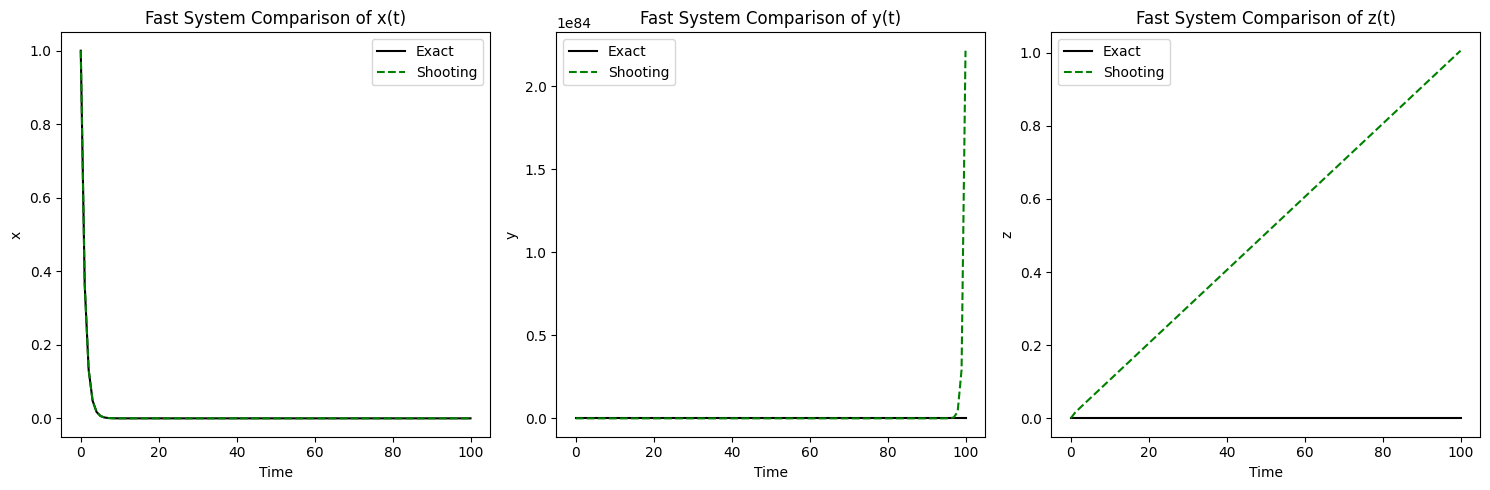

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(t, x_exact_fast, 'k-', label='Exact')
plt.plot(t, x_fast, 'g--', label='Shooting')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Fast System Comparison of x(t)')
plt.legend()

plt.subplot(132)
plt.plot(t, y_exact_fast, 'k-', label='Exact')
plt.plot(t, y_fast, 'g--', label='Shooting')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Fast System Comparison of y(t)')
plt.legend()

plt.subplot(133)
plt.plot(t, z_exact_fast, 'k-', label='Exact')
plt.plot(t, z_fast, 'g--', label='Shooting')
plt.xlabel('Time')
plt.ylabel('z')
plt.title('Fast System Comparison of z(t)')
#plt.ylim(0, 2)  # Set y-axis range from 0 to 1
plt.legend()

plt.tight_layout()
plt.show()